In [38]:
import numpy as np
import astropy.cosmology as cosmology
import scipy.optimize as spo
import scipy.stats as sps
from scipy.stats import norm
import scipy.linalg as la
import emcee
import corner
from datetime import datetime
import hickle
import bisect
import daft
import cProfile
import StringIO
import pstats
import sys
import pylab as pl
epsilon = sys.float_info.min
log_epsilon = sys.float_info.min_exp

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import rc
rc("font", family="serif", size=12)
rc("text", usetex=True)
colors = 'rbgcymk'

In [3]:
with open('data/data.hkl', 'r+') as in_file:
    sim_info = hickle.load(in_file)
    

print 'all keys in data: '
print sim_info.keys()

types = sim_info['types']
n_types = len(types)
print 'n_types: ', n_types

z_bins = sim_info['z_bins']
z_difs = z_bins[1:] - z_bins[:-1]
z_mids = (z_bins[1:] + z_bins[:-1]) / 2.
n_zs = len(z_difs)
print 'n_zs: ', n_zs

mu_bins = sim_info['mu_bins']
mu_difs = mu_bins[1:] - mu_bins[:-1]
mu_mids = (mu_bins[1:] + mu_bins[:-1]) / 2.
n_mus = len(mu_difs)
print 'n_mus: ', n_mus

ln_int_post = sim_info.get('interim ln posteriors')
num_sne = np.shape(ln_int_post)[0]

print np.shape(ln_int_post)
print 'num_sne: ', num_sne
def safe_log(arr, threshold=epsilon):
    shape = np.shape(arr)
    flat = arr.flatten()
    logged = np.log(np.array([max(a, threshold) for a in flat])).reshape(shape)
    return logged

def reg_vals(arr, threshold=log_epsilon):
    arr[arr < threshold] = threshold
    return arr

all keys in data: 
['interim ln posteriors', 'mu_bins', 'types', 'interim ln prior', 'z_bins']
n_types:  3
n_zs:  20
n_mus:  20
(100, 3, 20, 20)
num_sne:  100


## Integrating over both mu and z to get P(type)

In [21]:
type_tmp=np.zeros((100,3))

# Making sure to convert to posterior (not log post) and then do simple integral. This should be improved later
# scipy.integrate.simps(y, x=None, dx=1, axis=-1, even='avg')

for zi in range(1,n_zs):
    for mui in range(1,n_mus):
        
        type_tmp[:,:] +=np.exp(ln_int_post[:,:,zi,mui])*(z_bins[zi]-z_bins[zi-1])*(mu_bins[mui]-mu_bins[mui-1])


# Ensure that the probabilities are normalised
norm = np.sum(type_tmp, axis=1)
type_tmp[:,0]=type_tmp[:,0]/norm
type_tmp[:,1]=type_tmp[:,1]/norm
type_tmp[:,2]=type_tmp[:,2]/norm


## Now we assign the true type by the highest probability.

In [20]:
true_type = np.argmax(type_tmp, axis=1)


(100,)


(100, 3, 20, 20)
(100,)


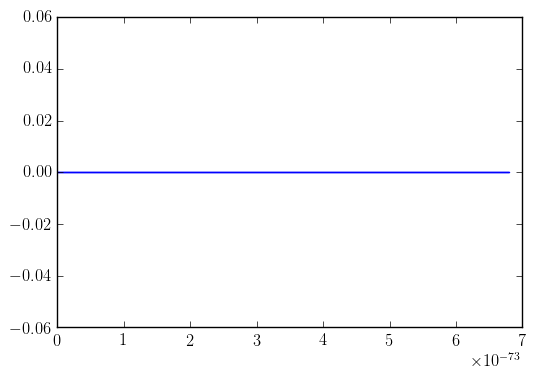

In [68]:
mumed = np.zeros(100)
zmed = np.zeros(100)
print np.shape(ln_int_post)
print np.shape(true_type[:])


for sn in range(5):
    for zi in range(1,n_zs):
        mutmp = np.exp(ln_int_post[sn,true_type[sn],zi,:])*(z_bins[zi]-z_bins[zi-1])
    mumed[sn] = np.median(mutmp)
    
    for mui in range(1,n_mus):
        ztmp = np.exp(ln_int_post[sn,true_type[sn],:,mui])*(mu_bins[mui]-mu_bins[mui-1])
    zmed[sn] = np.median(ztmp) 
    

pl.plot(zmed, mumed)
    

#for zi in range(1, n_zs):
#    muvec[zi] +=np.exp(ln_int_post[:,true_type[zi],zi,:])*(z_bins[zi]-z_bins[zi-1])

#print muvec